# IMPORTACION DE LIBRERIAS Y LECTURA DEL DATASET

In [670]:
# Librerías básicas
import pandas as pd
import numpy as np
from tabulate import tabulate

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

#Libreria para separacion de datos train y test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Librerias a usar para el modelo de machine learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [671]:
#Lectura del dataset
df = pd.read_csv("airline_passenger_satisfaction.csv")

In [672]:
# Configura Pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

df.head(10)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,3,2,2,2,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,4,5,5,5,5,5,5,5,4,5,4,4,0.0,satisfied
8,8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,2,2,4,3,3,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,9,65725,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,3,4,2,3,3,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


# NULOS E IMPUTACION DE NULOS

- Se mira información del dataset: columnas 25, filas 103903, y solo la columna Arrival Delay in Minutes tiene nulos.

In [673]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

- Se rectifica que solo haya una columna con datos nulos efectivamente solo hay en la columna Arrival Delay in Minutes **310 datos nulos**, posteriormente se decidirá que hacer con estos nulos.

In [674]:
df.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [675]:
df.nunique()

Unnamed: 0                           103904
id                                   103904
Gender                                    2
Customer Type                             2
Age                                      75
Type of Travel                            2
Class                                     3
Flight Distance                        3802
Inflight wifi service                     6
Departure/Arrival time convenient         6
Ease of Online booking                    6
Gate location                             6
Food and drink                            6
Online boarding                           6
Seat comfort                              6
Inflight entertainment                    6
On-board service                          6
Leg room service                          6
Baggage handling                          5
Checkin service                           6
Inflight service                          6
Cleanliness                               6
Departure Delay in Minutes      

- Revisamos los valores unicos de la columna "Arrival Delay in Minutes" para ver si se podia pasar de float a int.

In [676]:
# Utiliza el método unique() para obtener todos los valores únicos
unique_values = df['Arrival Delay in Minutes'].unique()

# Muestra todos los valores únicos en la columna 'Arrival Delay in Minutes'
for value in unique_values:
    print(value)

18.0
6.0
0.0
9.0
23.0
8.0
35.0
51.0
10.0
5.0
4.0
29.0
44.0
28.0
12.0
120.0
24.0
1.0
20.0
31.0
15.0
48.0
26.0
49.0
2.0
37.0
50.0
3.0
19.0
72.0
11.0
34.0
62.0
27.0
52.0
13.0
82.0
30.0
16.0
7.0
122.0
179.0
125.0
17.0
nan
89.0
101.0
14.0
61.0
32.0
33.0
41.0
191.0
138.0
53.0
22.0
57.0
65.0
76.0
107.0
92.0
164.0
21.0
40.0
55.0
185.0
63.0
77.0
86.0
91.0
100.0
54.0
36.0
70.0
139.0
67.0
163.0
128.0
180.0
93.0
121.0
45.0
105.0
126.0
56.0
73.0
212.0
88.0
241.0
172.0
175.0
111.0
99.0
25.0
42.0
226.0
46.0
131.0
260.0
69.0
142.0
58.0
75.0
38.0
66.0
39.0
103.0
307.0
156.0
74.0
109.0
155.0
60.0
154.0
43.0
147.0
217.0
124.0
47.0
150.0
116.0
171.0
84.0
123.0
165.0
94.0
83.0
336.0
59.0
219.0
87.0
459.0
68.0
104.0
133.0
134.0
81.0
259.0
80.0
79.0
222.0
203.0
354.0
214.0
78.0
95.0
71.0
110.0
85.0
146.0
196.0
98.0
470.0
264.0
149.0
113.0
119.0
106.0
216.0
160.0
285.0
115.0
186.0
211.0
323.0
176.0
167.0
242.0
284.0
200.0
145.0
108.0
174.0
132.0
313.0
331.0
288.0
118.0
225.0
64.0
324.0
190.0
177.0
136.0
320.0

In [677]:
# Para llenar los valores nulos con la moda (valor más frecuente):
#df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mode()[0], inplace=True)

# Para eliminar las filas con valores nulos
df.dropna(subset=['Arrival Delay in Minutes'], inplace=True)

In [678]:
# Para convertir una columna de tipo float a int 
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)

### SE BORRAN COLUMNAS QUE NO SIRVEN 

In [679]:
columna_a_borrar = ['Unnamed: 0', "id"]
df = df.drop(columna_a_borrar, axis=1)

# ANALISIS DE VARIABLES NUMERICAS

In [680]:
var_numericas = ["Age","Flight Distance","Inflight wifi service","Departure/Arrival time convenient",	"Ease of Online booking",
                 "Gate location",	"Food and drink",	"Online boarding",	"Seat comfort",	"Inflight entertainment",	"On-board service",	
                 "Leg room service",	"Baggage handling",	"Checkin service",	"Inflight service",	"Cleanliness",	"Departure Delay in Minutes",	
                 "Arrival Delay in Minutes"]


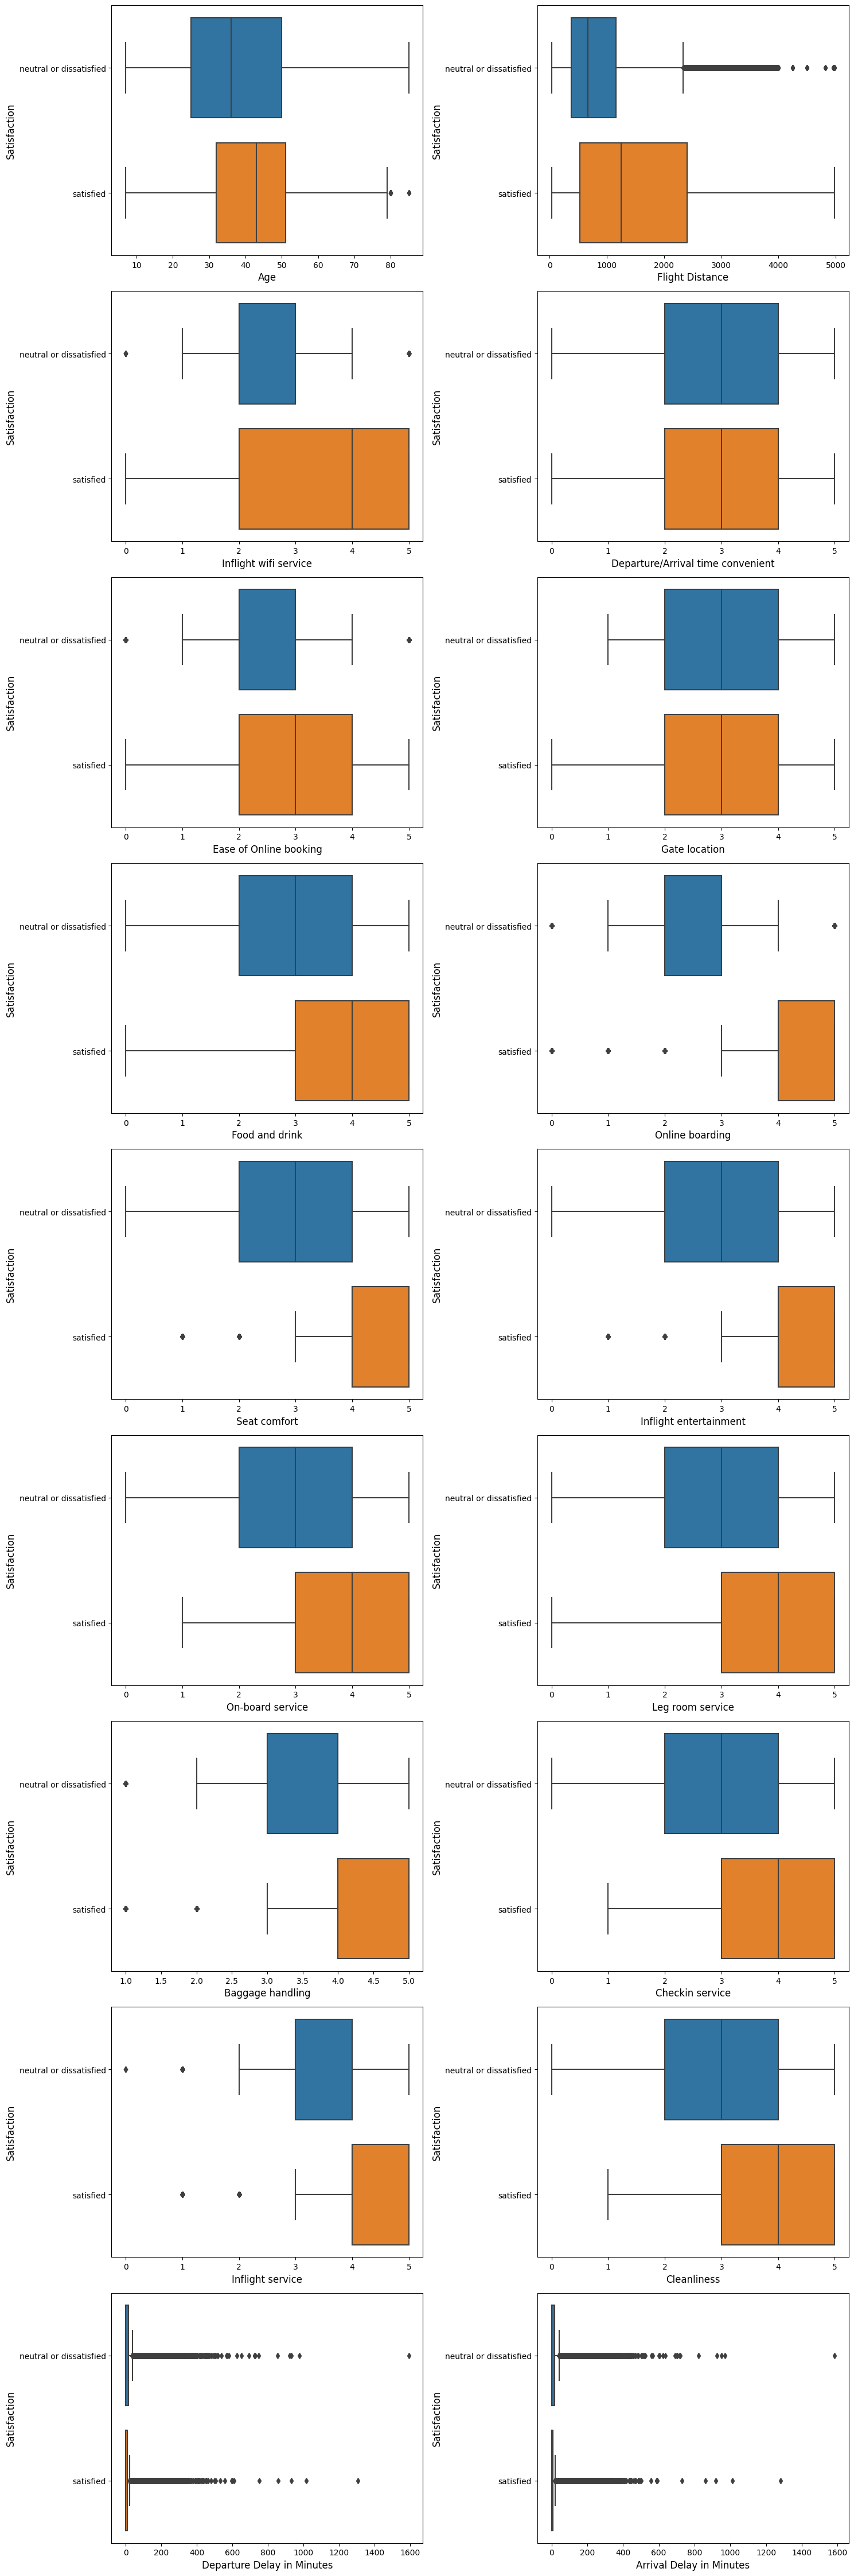

In [681]:
import math

n_rows, n_cols = math.ceil(len(var_numericas) / 2), 2
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for num_col in var_numericas:
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(data=df, x=num_col, y="satisfaction", ax=ax[row, col])
    ax[row, col].set_xlabel(num_col, fontsize=12)
    ax[row, col].set_ylabel('Satisfaction', fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

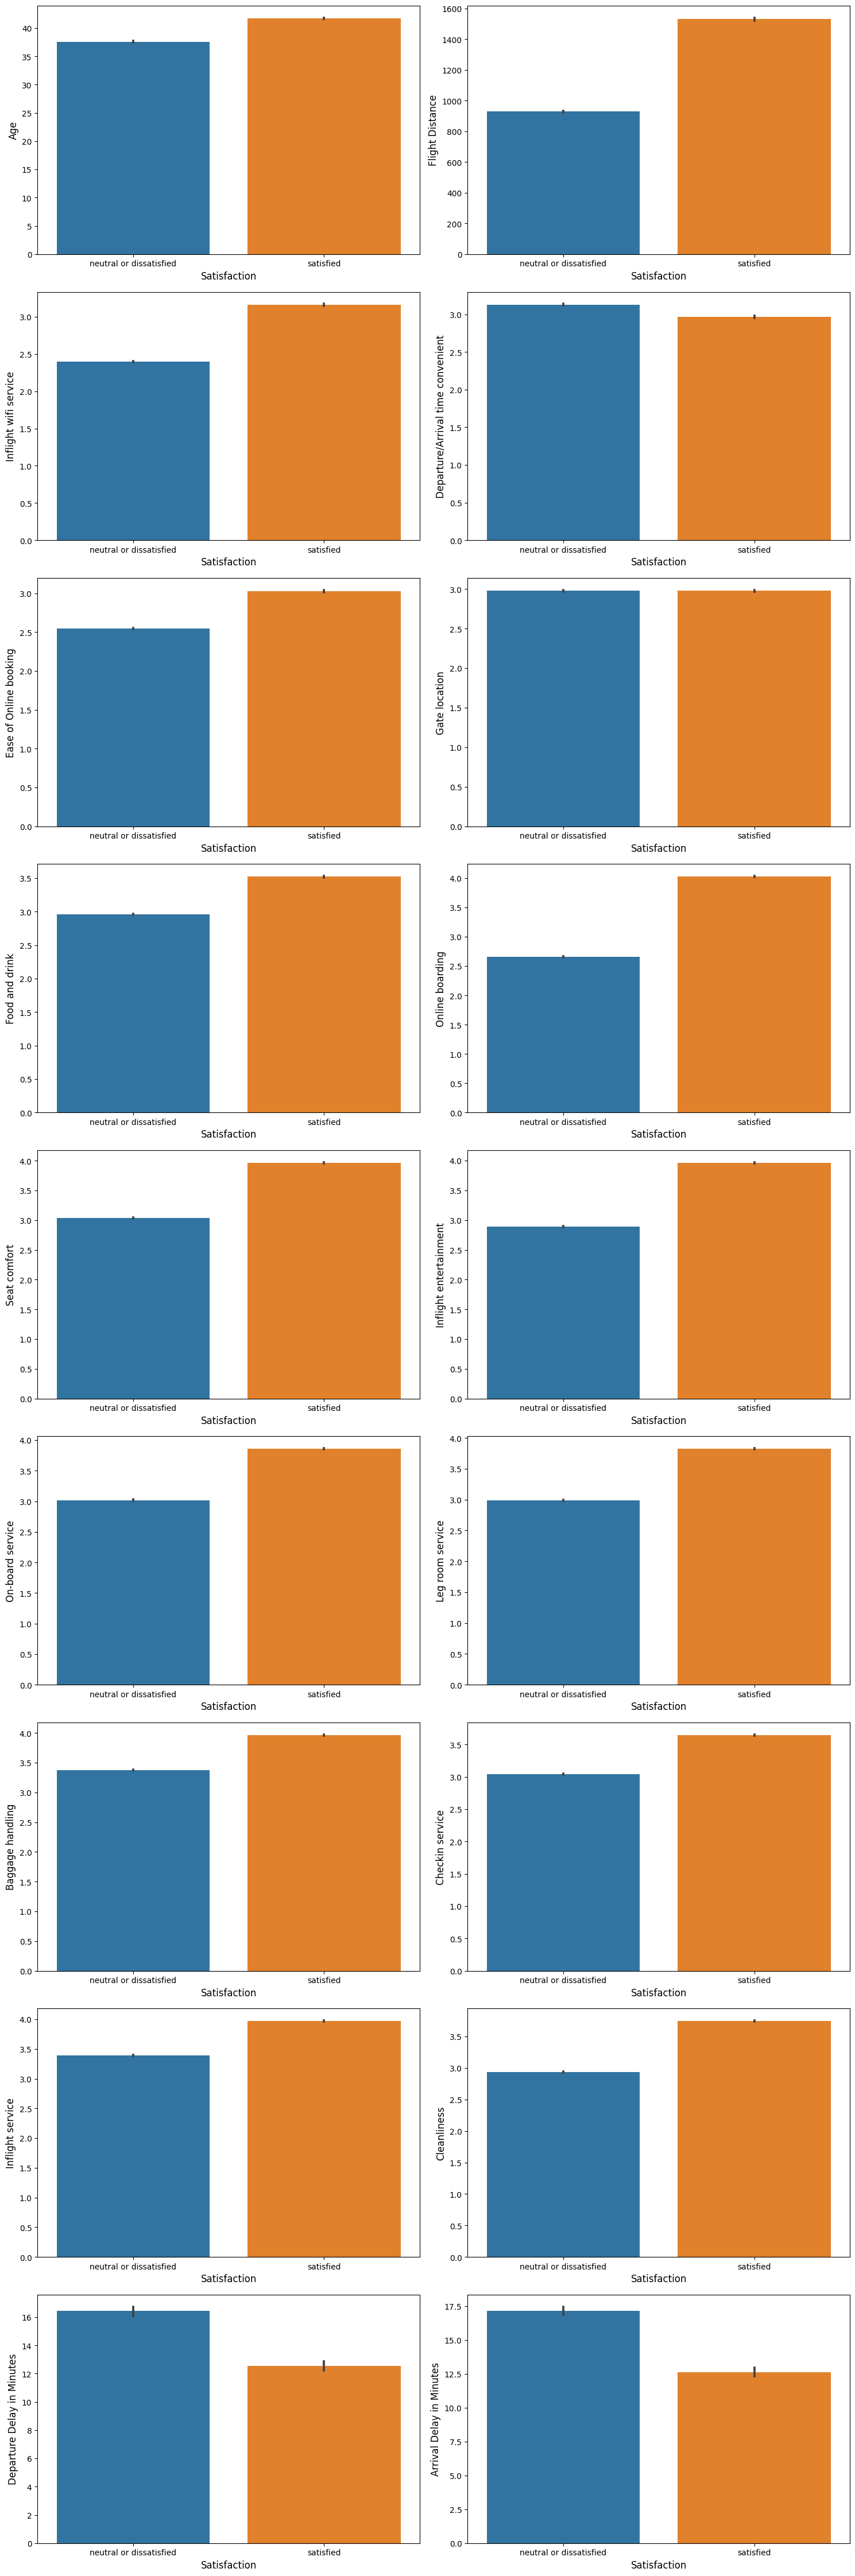

In [682]:
# Calcula el número de filas y columnas para organizar los subplots
n_rows, n_cols = math.ceil(len(var_numericas) / 2), 2

# Crea la figura y los ejes de los subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for num_col in var_numericas:
    row = i // n_cols
    col = i % n_cols
    sns.barplot(data=df, x="satisfaction", y=num_col, ax=ax[row, col])
    ax[row, col].set_xlabel("Satisfaction", fontsize=12)
    ax[row, col].set_ylabel(num_col, fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

In [683]:
df.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000,103594.000000
mean,39.380466,1189.325202,2.729753,3.060081,2.756984,2.977026,3.202126,3.250497,3.439765,3.358341,3.382609,3.351401,3.631687,3.304323,3.640761,3.286397,14.747939,15.178678
std,15.113125,997.297235,1.327866,1.525233,1.398934,1.277723,1.329401,1.349433,1.318896,1.333030,1.288284,1.315409,1.181051,1.265396,1.175603,1.312194,38.116737,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [684]:
df[["Seat comfort"]].value_counts()

Seat comfort
4               31682
5               26393
3               18641
2               14846
1               12031
0                   1
Name: count, dtype: int64

In [685]:
df[["Inflight wifi service"]].value_counts()

Inflight wifi service
3                        25789
2                        25755
4                        19737
1                        17781
5                        11436
0                         3096
Name: count, dtype: int64

# ANALISIS DE VARIABLES CATEGORICAS

In [686]:
var_categoricas =[column for column, count in dict(df.nunique()).items()
             if (df[column].dtype=="O") & (count<10)]
var_categoricas

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

In [687]:
# Obtener categorías únicas (incluyendo valores nulos) de las columnas deseadas
categorias_por_columna = {}
for columna in var_categoricas:
    categorias = df[columna].unique()
    categorias = [str(cat) if not pd.isnull(cat) else 'NaN' for cat in categorias]
    categorias_por_columna[columna] = categorias

# Mostrar las categorías en una tabla usando tabulate
tabla = []
for columna, categorias in categorias_por_columna.items():
    tabla.append([columna, ", ".join(categorias)])

tabla_formateada = tabulate(tabla, headers=["Columna", "Datos Categorícos (con Nulos)"], tablefmt="grid")
print(tabla_formateada)

+----------------+------------------------------------+
| Columna        | Datos Categorícos (con Nulos)      |
+================+====================================+
| Gender         | Male, Female                       |
+----------------+------------------------------------+
| Customer Type  | Loyal Customer, disloyal Customer  |
+----------------+------------------------------------+
| Type of Travel | Personal Travel, Business travel   |
+----------------+------------------------------------+
| Class          | Eco Plus, Business, Eco            |
+----------------+------------------------------------+
| satisfaction   | neutral or dissatisfied, satisfied |
+----------------+------------------------------------+


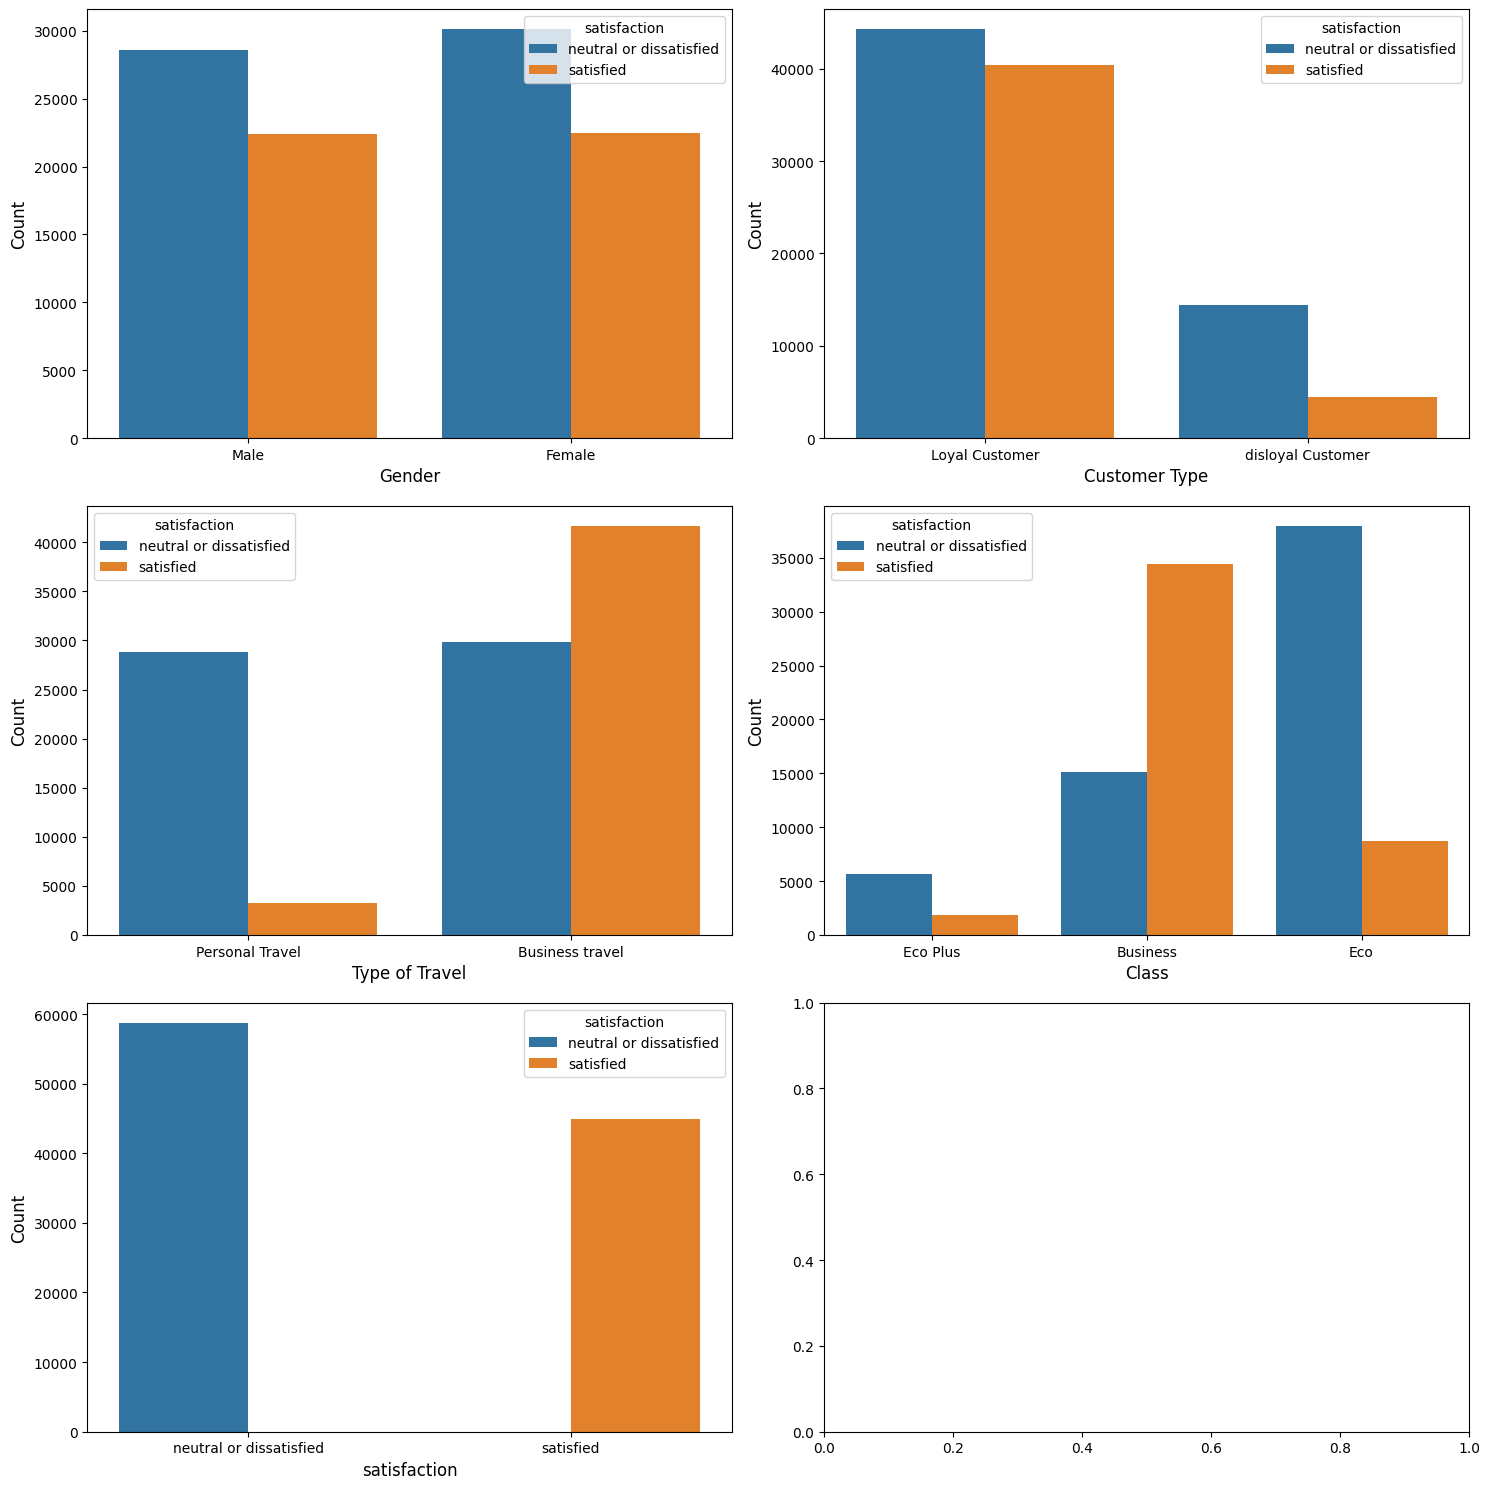

In [688]:
# Calcula el número de filas y columnas para organizar los subplots
n_rows, n_cols = math.ceil(len(var_categoricas) / 2), 2

# Crea la figura y los ejes de los subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for var_cat in var_categoricas:
    row = i // n_cols
    col = i % n_cols
    sns.countplot(data=df, x=var_cat, hue="satisfaction", ax=ax[row, col])
    ax[row, col].set_xlabel(var_cat, fontsize=12)
    ax[row, col].set_ylabel('Count', fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

# OUTLIERS

LAS SIGUIENTES LINEAS DE CODIGO SE USARÁN PARA BUSCAR OUTLIERS Y BORRARLOS

In [693]:
mean = df["Flight Distance"].mean()
std = df["Flight Distance"].std()

threshold = 3 * std

outliers = df[abs(df["Flight Distance"] - mean) > threshold]

In [694]:
df = df.drop(index=outliers.index)

# DIVISION DE DATOS

In [695]:
# Separar características (X) y variable objetivo (y)
X = df.drop(columns=['satisfaction'])  # Características
y = df['satisfaction']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Codificación one-hot para variables categóricas en los conjuntos de entrenamiento y prueba
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

### ESCALAMIENTO

In [696]:
# Se hizo un escalado de los datos aunque no era necesario ya que no cambió el resultado de las predicciones.
scaler = StandardScaler()

# Ajustar el escalador a los datos de entrenamiento y transformar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train_encoded)

# Usar el mismo escalador para transformar los datos de prueba
X_test_scaled = scaler.transform(X_test_encoded)

In [697]:
# Crear una instancia del modelo Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, n_estimators=150, random_state=42)

# Convertir variables categóricas en valores numéricos usando Label Encoding
label_encoder = LabelEncoder()
X_train_encoded = X_train.copy()  # Hacer una copia de los datos originales
X_test_encoded = X_test.copy()

for col in categorical_columns:
    X_train_encoded[col] = label_encoder.fit_transform(X_train_encoded[col])
    X_test_encoded[col] = label_encoder.transform(X_test_encoded[col])


### BUSQUEDA DE HIPERPARAMETROS

Con este codigo se buscaron los mejores hiperparametro los cuales se utilizan y ya se comenta para no tener que usar mas esta linea de codigo y poner mas lento el programa.

### Best Gradient Boosting Model - Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}

In [ ]:
# Definir la cuadrícula de hiperparámetros a explorar
# param_grid = {
    #'n_estimators': [50, 100, 150],
    #'learning_rate': [0.01, 0.1, 0.2],
    #'max_depth': [3, 5, 7]

# Realizar Grid Search con validación cruzada
# grid_search = GridSearchCV(gb_model, param_grid, cv=5)
# grid_search.fit(X_train_encoded, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
# best_params = grid_search.best_params_
# best_gb_model = grid_search.best_estimator_

In [698]:
# Entrenar el modelo en el conjunto de entrenamiento (X_train_encoded, y_train)
gb_model.fit(X_train_encoded, y_train)

# Realizar predicciones en el conjunto de prueba (X_test_encoded)
gb_pred_test = gb_model.predict(X_test_encoded)

# Calcular la precisión en el conjunto de entrenamiento y prueba
gb_pred_train = gb_model.predict(X_train_encoded)
gb_accuracy_train = accuracy_score(y_train, gb_pred_train)
gb_accuracy_test = accuracy_score(y_test, gb_pred_test)

# Evaluar el rendimiento del modelo
gb_accuracy = accuracy_score(y_test, gb_pred_test)
gb_conf_matrix = confusion_matrix(y_test, gb_pred_test)
gb_classification_rep = classification_report(y_test, gb_pred_test)

print("Best Gradient Boosting Model - Best Params:", best_params)
print("Gradient Boosting - Accuracy:", gb_accuracy)
print("Gradient Boosting - Confusion Matrix:\n", gb_conf_matrix)
print("Gradient Boosting - Classification Report:\n", gb_classification_rep)
print("Training Accuracy:", gb_accuracy_train)
print("Test Accuracy:", gb_accuracy_test)

Best Gradient Boosting Model - Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Gradient Boosting - Accuracy: 0.964747923507823
Gradient Boosting - Confusion Matrix:
 [[11637   243]
 [  487  8341]]
Gradient Boosting - Classification Report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     11880
              satisfied       0.97      0.94      0.96      8828

               accuracy                           0.96     20708
              macro avg       0.97      0.96      0.96     20708
           weighted avg       0.96      0.96      0.96     20708

Training Accuracy: 0.9773748007920027
Test Accuracy: 0.964747923507823


In [699]:
# Calcular la diferencia entre la precisión en entrenamiento y prueba
gb_accuracy_difference = gb_accuracy_train - gb_accuracy_test
print("Accuracy Difference:", gb_accuracy_difference)

Accuracy Difference: 0.01262687728417966


### RESULTADOS CON OUTLIERS
Best Gradient Boosting Model - Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Gradient Boosting - Accuracy: 0.9637048120083016
Gradient Boosting - Confusion Matrix:
 [[11424   231]
 [  521  8543]]
Gradient Boosting - Classification Report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     11655
              satisfied       0.97      0.94      0.96      9064

               accuracy                           0.96     20719
              macro avg       0.97      0.96      0.96     20719
           weighted avg       0.96      0.96      0.96     20719

Training Accuracy: 0.9768205128205129
Test Accuracy: 0.9637048120083016

### RESULTADOS SIN OUTLIERS COLUMNA "Flight Distance"

Best Gradient Boosting Model - Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Gradient Boosting - Accuracy: 0.964747923507823
Gradient Boosting - Confusion Matrix:
 [[11637   243]
 [  487  8341]]
Gradient Boosting - Classification Report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     11880
              satisfied       0.97      0.94      0.96      8828

               accuracy                           0.96     20708
              macro avg       0.97      0.96      0.96     20708
           weighted avg       0.96      0.96      0.96     20708

Training Accuracy: 0.9773748007920027
Test Accuracy: 0.964747923507823

# ANALISIS DE CORRELACION

In [700]:
df = pd.get_dummies(df, columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'])

corr_matrix = df.corr()
print(corr_matrix)

                                           Age  Flight Distance  \
Age                                   1.000000         0.100286   
Flight Distance                       0.100286         1.000000   
Inflight wifi service                 0.017512         0.007104   
Departure/Arrival time convenient     0.037974        -0.019753   
Ease of Online booking                0.024487         0.065893   
Gate location                        -0.001597         0.004495   
Food and drink                        0.022907         0.057345   
Online boarding                       0.208845         0.216003   
Seat comfort                          0.160403         0.158324   
Inflight entertainment                0.076485         0.129323   
On-board service                      0.057323         0.110513   
Leg room service                      0.040484         0.133755   
Baggage handling                     -0.047665         0.063182   
Checkin service                       0.035038         0.07352

### CONCLUSION

- Edad: La edad tiene una correlación positiva débil (0.137) con la satisfacción. Esto sugiere que los pasajeros mayores tienden a estar ligeramente más satisfechos en comparación con los pasajeros más jóvenes.
- Distancia del Vuelo (Flight Distance): La distancia del vuelo tiene una correlación negativa moderada (-0.299) con la satisfacción. Esto indica que a medida que la distancia del vuelo aumenta, la satisfacción tiende a disminuir. Los vuelos más largos podrían estar asociados con niveles de satisfacción más bajos.
  
- Embarque en Línea (Online Boarding): La variable "Online Boarding" tiene una correlación negativa fuerte (-0.503) con la satisfacción. Esto significa que los pasajeros que tienen una experiencia de embarque en línea mejor tienden a estar más satisfechos con el servicio.
  
- Comodidad del Asiento (Seat Comfort): La comodidad del asiento tiene una correlación positiva fuerte (0.349) con la satisfacción. Los pasajeros que encuentran cómodos los asientos tienden a estar más satisfechos.

- Entretenimiento a Bordo (Inflight Entertainment): El entretenimiento a bordo tiene una correlación positiva fuerte (0.398) con la satisfacción. Los pasajeros que disfrutan del entretenimiento a bordo tienden a estar más satisfechos.

- Limpieza (Cleanliness): La limpieza tiene una correlación positiva moderada (0.305) con la satisfacción. Los pasajeros que perciben que la cabina está limpia tienden a estar más satisfechos.
  
- Clase (Class): La clase de vuelo también tiene una influencia en la satisfacción. La variable "Class_Eco" tiene una correlación negativa moderada con la satisfacción, mientras que "Class_Business" tiene una correlación positiva moderada. Esto sugiere que los pasajeros de clase económica pueden estar menos satisfechos en comparación con los pasajeros de clase business.
  
- Tipo de Viaje (Type of Travel): La variable "Type of Travel_Personal Travel" tiene una correlación negativa moderada con la satisfacción, lo que sugiere que los viajes de negocios podrían estar asociados con niveles de satisfacción más altos en comparación con los viajes personales.
  
- Tipo de Cliente (Customer Type): La variable "Customer Type_Loyal Customer" tiene una correlación positiva moderada con la satisfacción, lo que sugiere que los clientes leales tienden a estar más satisfechos.
  
- Tiempo de Llegada y Salida Conveniente (Departure/Arrival Time Convenient): Esta característica tiene una correlación positiva débil (0.052) con la satisfacción. Los pasajeros que consideran que el tiempo de llegada y salida es conveniente tienden a estar ligeramente más satisfechos.

In [701]:
df = pd.get_dummies(df, columns=['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'])

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

KeyError: "None of [Index(['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'], dtype='object')] are in the [columns]"